# Assignment 4: Word Embeddings 

Welcome to the fourth (and last) programming assignment of Course 2! 

In this assignment, you will practice how to compute word embeddings and use them for sentiment analysis.
- To implement sentiment analysis, you can go beyond counting the number of positive words and negative words. 
- You can find a way to represent each word numerically, by a vector. 
- The vector could then represent syntactic (i.e. parts of speech) and semantic (i.e. meaning) structures. 

In this assignment, you will explore a classic way of generating word embeddings or representations.
- You will implement a famous model called the continuous bag of words (CBOW) model. 

By completing this assignment you will:

- Train word vectors from scratch.
- Learn how to create batches of data.
- Understand how backpropagation works.
- Plot and visualize your learned word vectors.

Knowing how to train these models will give you a better understanding of word vectors, which are building blocks to many applications in natural language processing.

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/probabilistic-models-in-nlp/supplement/saGQf/how-to-refresh-your-workspace).

## Table of Contents

- [1 - The Continuous Bag of Words Model](#1)
- [2 - Training the Model](#2)
    - [2.1 - Initializing the Model](#2.1)
        - [Exercise 1 - initialize_model (UNQ_C1)](#ex-1)
    - [2.2 - Softmax](#2.2)
        - [Exercise 2 - softmax (UNQ_C2)](#ex-2)
    - [2.3 - Forward Propagation](#2.3)
        - [Exercise 3 - forward_prop (UNQ_C3)](#ex-3)
    - [2.4 - Cost Function](#2.4)
    - [2.5 - Training the Model - Backpropagation](#2.5)
        - [Exercise 4 - back_prop (UNQ_C4)](#ex-4)
    - [2.6 - Gradient Descent](#2.6)
        - [Exercise 5 - gradient_descent (UNQ_C5)](#ex-5)
- [3 - Visualizing the Word Vectors](#3)


<a name='1'></a>
## 1 - The Continuous Bag of Words Model

Let's take a look at the following sentence: 
>**'I am happy because I am learning'**. 

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if you were to choose a context half-size of say $C = 2$, then you would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am] 

> $C$ words after: [because, I] 

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of your model will look like this:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='images/a1-cbow-model-architecture.png' alt="alternate text" width="width" style="width:600px;" /> Figure 1 </div>

Where $\bar x$ is the average of all the one hot vectors of the context words. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='images/a1-cbow-model-inputs.png' alt="alternate text" width="width" style="width:600px;" /> Figure 2 </div>

Once you have encoded all the context words, you can use $\bar x$ as the input to your model. 

The architecture you will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

In [1]:
# Import Python libraries and helper functions (in utils) 
import numpy as np
import nltk

from utils import get_batches, compute_pca, get_dict
import w4_unittest

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shivam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [3]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('./data/shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60976 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [4]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5775
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [5]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5775


In [6]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2744
Word which has index 2743:   kinds


<a name='2'></a>
## 2 - Training the Model

<a name='2.1'></a>
### 2.1 - Initializing the Model

You will now initialize two matrices and two vectors. 
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$. 
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$. 
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters. 

<a name='ex-1'></a>
### Exercise 1 - initialize_model
Please use [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) to generate matrices that are initialized with random values from a uniform distribution, ranging between 0 and 1.

**Note:** In the next cell you will encounter a random seed. Please **DO NOT** modify this seed so your solution can be tested correctly.

In [7]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C1 GRADED FUNCTION: initialize_model
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N, V)
    
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    
    # b1 has shape (N,1)
    b1 = np.random.rand(N, 1)
    
    # b2 has shape (V,1)
    b2 = np.random.rand(V, 1)
    
    ### END CODE HERE ###
    return W1, W2, b1, b2

In [8]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


##### Expected Output 

```text
tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)
```

In [9]:
# Test your function
w4_unittest.test_initialize_model(initialize_model)

 All tests passed


<a name='2.2'></a>
### 2.2 - Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- Array indexing in code starts at 0.
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$).
- $i$ goes from 0 to |V| - 1.


<a name='ex-2'></a>
### Exercise 2 - softmax
**Instructions**: Implement the softmax function below. 

- Assume that the input $z$ to `softmax` is a 2D array
- Each training example is represented by a vector of shape (V, 1) in this 2D array.
- There may be more than one column, in the 2D array, because you can put in a batch of examples to increase efficiency.  Let's call the batch size lowercase $m$, so the $z$ array has shape (V, m)
- When taking the sum from $i=1 \cdots V-1$, take the sum for each column (each example) separately.

Please use
- numpy.exp
- numpy.sum (set the axis so that you take the sum of each column in z)

In [10]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C2 GRADED FUNCTION: softmax
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate yhat (softmax)
    z_exp = np.exp(z)
    yhat = z_exp / np.sum(z_exp, axis = 0)
    ### END CODE HERE ###
    return yhat

In [11]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

##### Expected Ouput

```text
array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])
```

In [12]:
# Test your function
w4_unittest.test_softmax(softmax)

 All tests passed


<a name='2.3'></a>
### 2.3 - Forward Propagation

<a name='ex-3'></a>
### Exercise 3 - forward_prop
Implement the forward propagation $z$ according to equations (1) to (3). <br>

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 h &= ReLU(h)  \tag{2} \\
 z &= W_2 \  h + b_2   \tag{3} \\
\end{align}

For that, you will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use numpy.maximum(x1,x2) to get the maximum of two values</li>
    <li>Use numpy.dot(A,B) to matrix multiply A and B</li>
</ul>
</p>


In [13]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C3 GRADED FUNCTION: forward_prop
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate h
    h = np.dot(W1, x) + b1
  
    # Apply the relu on h, 
    # store the relu in h
    h = np.maximum(0, h)

    # Calculate z
    z = np.dot(W2, h) + b2

    ### END CODE HERE ###

    return z, h

In [14]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
#print(tmp_x)
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


##### Expected output

```text
x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]
```

In [15]:
# Test your function
w4_unittest.test_forward_prop(forward_prop)

 All tests passed


<a name='2.4'></a>
### 2.4 - Cost Function

- We have implemented the *cross-entropy* cost function for you.

In [16]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [17]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5775, 4)
tmp_y.shape (5775, 4)
tmp_W1.shape (50, 5775)
tmp_W2.shape (5775, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5775, 1)
tmp_z.shape: (5775, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5775, 4)
call compute_cost
tmp_cost 10.3511


##### Expected output

```text
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 8.9542
```

<a name='2.5'></a>
### 2.5 - Training the Model - Backpropagation

<a name='ex-4'></a>
### Exercise 4 - back_prop
Now that you have understood how the CBOW model works, you will train it. <br>
You created a function for the forward propagation. Now you will implement a function that computes the gradients to backpropagate the errors.

**Note**: `z1` is calculated as `W1⋅x + b1` in this function. In practice, you would save it already when making forward propagation and just re-use here, but for simplicity, it is calculated again in `back_prop`.

As reference, below are the equations of backpropagation as taught in the [lecture](https://www.coursera.org/learn/probabilistic-models-in-nlp/lecture/mPJwt/training-a-cbow-model-backpropagation-and-gradient-descent):
<div style="width:image width px; font-size:100%; text-align:center;"><img src='images/a1-back-prop-eqs.png' alt="alternate text" width="width" height="height" style="width:600px;" /> </div>

In [18]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C4 GRADED FUNCTION: back_prop
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute z1 as "W1⋅x + b1"
    z1 = np.dot(W1, x) + b1
    
    ### START CODE HERE (Replace instanes of 'None' with your code) ###
    
    # Compute y_diff as (Yhat - Y)
    y_diff = yhat - y
    
    # Compute l1 as W2^T (Yhat - Y)
    l1 = np.dot(W2.T, y_diff)

    # if z1 < 0, then l1 = 0
    # otherwise l1 = l1
    # (this is already implemented for you)
    
    l1[z1 < 0] = 0 # use "l1" to compute gradients below

    # compute the gradient for W1
    grad_W1 = (1 / batch_size) * np.dot(l1, x.T)

    # Compute gradient of W2
    grad_W2 = (1 / batch_size) * np.dot(y_diff, h.T)
    
    # compute gradient for b1
    grad_b1 = (1 / batch_size) * np.sum(l1, axis = 1, keepdims = True)

    # compute gradient for b2
    grad_b2 = (1 / batch_size) * np.sum(y_diff, axis = 1, keepdims = True)
    ### END CODE HERE ####
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [19]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5775, 4)
tmp_y.shape (5775, 4)

Initialize weights and biases
tmp_W1.shape (50, 5775)
tmp_W2.shape (5775, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5775, 1)

Forwad prop to get z and h
tmp_z.shape: (5775, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5775, 4)

call back_prop
tmp_grad_W1.shape (50, 5775)
tmp_grad_W2.shape (5775, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5775, 1)


##### Expected output

```text
get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)
```

In [20]:
# Test your function
w4_unittest.test_back_prop(back_prop)

 All tests passed


<a name='2.6'></a>
### 2.6 - Gradient Descent

<a name='ex-5'></a>
### Exercise 5 - gradient_descent
Now that you have implemented a function to compute the gradients, you will implement batch gradient descent over your training set. 

**Hint:** For that, you will use `initialize_model` and the `back_prop` functions which you just created (and the `compute_cost` function). You can also use the provided `get_batches` helper function:

```for x, y in get_batches(data, word2Ind, V, C, batch_size):```

```...```

Also: print the cost after each batch is processed (use batch size = 128)

In [21]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C5 GRADED FUNCTION: gradient_descent
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

    batch_size = 128
    # batch_size = 512
    iters = 0
    C = 2 
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###                
        # get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
                
        # get yhat
        yhat = softmax(z)
        
        # get cost
        cost = compute_cost(y, yhat, batch_size)
        
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
            
        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # update weights and biases
        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2

        ### END CODE HERE ###
        
        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [22]:
# test your function

C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 9.513211
iters: 20 cost: 9.476105
iters: 30 cost: 9.543887
iters: 40 cost: 9.370119
iters: 50 cost: 8.752134
iters: 60 cost: 8.645475
iters: 70 cost: 8.777353
iters: 80 cost: 8.683993
iters: 90 cost: 8.785594
iters: 100 cost: 8.286367
iters: 110 cost: 8.527792
iters: 120 cost: 8.414913
iters: 130 cost: 8.099485
iters: 140 cost: 8.282044
iters: 150 cost: 8.239267


##### Expected Output

```text
iters: 10 cost: 9.686791
iters: 20 cost: 10.297529
iters: 30 cost: 10.051127
iters: 40 cost: 9.685962
iters: 50 cost: 9.369307
iters: 60 cost: 9.400293
iters: 70 cost: 9.060542
iters: 80 cost: 9.054266
iters: 90 cost: 8.765818
iters: 100 cost: 8.516531
iters: 110 cost: 8.708745
iters: 120 cost: 8.660616
iters: 130 cost: 8.544338
iters: 140 cost: 8.454268
iters: 150 cost: 8.475693
```        
        
Your numbers may differ a bit depending on which version of Python you're using.

In [23]:
# Test your function
w4_unittest.test_gradient_descent(gradient_descent, data, word2Ind, N=10, V=len(word2Ind), num_iters=15)

name default_check


iters: 10 cost: 9.056839
name small_check
iters: 10 cost: 8.917110
 All tests passed


<a name='3'></a>
## 3 - Visualizing the Word Vectors

In this part you will visualize the word vectors trained using the function you just coded above. 

In [24]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2744, 3949, 2960, 3022, 5672, 1452, 5671, 4189, 2315, 4276]


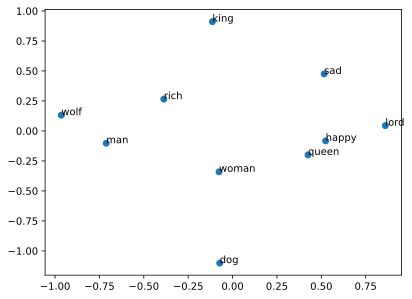

In [25]:
result = compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

You can see that man and king are next to each other. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

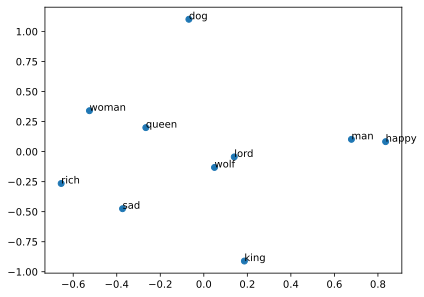

In [26]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()